### 70. 単語ベクトルの和による特徴量

データを読み込んで単語に分割する

In [1]:
import re
import spacy

In [2]:
nlp = spacy.load('en')
categories = ['b', 't', 'e', 'm']
category_names = ['business', 'science and technology', 'entertainment', 'health']

In [3]:
def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [d.text for d in x]
    return x

def read_feature_dataset(filename):
    with open(filename) as f:
        dataset = f.read().splitlines()
    dataset = [line.split('\t') for line in dataset]
    dataset_t = [categories.index(line[0]) for line in dataset]
    dataset_x = [tokenize(line[1]) for line in dataset]
    return dataset_x, dataset_t

In [4]:
train_x, train_t = read_feature_dataset('data/train.txt')
valid_x, valid_t = read_feature_dataset('data/valid.txt')
test_x, test_t = read_feature_dataset('data/test.txt')

特徴ベクトルに変換する

In [5]:
# ! pip install torch

In [6]:
import torch
from gensim.models import KeyedVectors

/home/koyama.s/nlp10021/envs/nlp10021/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [8]:
def sent_to_vector(sent):
    lst = [torch.tensor(model[token]) for token in sent if token in model]
    return sum(lst) / len(lst)

def dataset_to_vector(dataset):
    return torch.stack([sent_to_vector(x) for x in dataset])

In [9]:
train_v = dataset_to_vector(train_x)
valid_v = dataset_to_vector(valid_x)
test_v = dataset_to_vector(test_x)

In [10]:
train_v[0]

tensor([ 9.0576e-02,  5.4932e-02, -7.7393e-02,  1.1810e-01, -3.8849e-02,
        -2.6074e-01, -6.4484e-02,  3.2715e-02,  1.1792e-01, -3.4363e-02,
        -1.5137e-02, -1.7090e-02,  7.2632e-02,  1.0742e-02,  1.1194e-01,
         5.8945e-02,  1.6275e-01,  1.5393e-01,  7.0496e-02, -1.5210e-01,
         2.8320e-02,  1.1719e-02,  1.9702e-01, -1.5610e-02, -2.3438e-02,
         1.8921e-02,  2.8687e-02, -2.3438e-02,  2.3315e-02, -5.7480e-02,
         2.1973e-03, -1.0449e-01, -9.7534e-02, -1.3694e-01,  1.6144e-01,
        -2.6062e-02,  3.1250e-02,  1.9482e-01, -1.0788e-01,  7.2571e-02,
        -1.3916e-02,  1.1121e-01,  7.0801e-03, -4.1016e-02, -1.9580e-01,
         1.7334e-02,  1.0986e-02, -6.9485e-03,  9.2773e-02,  7.2205e-02,
         6.8298e-02, -5.3589e-02, -1.7447e-01,  1.0245e-01, -8.6426e-02,
        -9.0942e-03, -1.7212e-01, -1.3789e-01, -1.0355e-01,  1.9226e-02,
         1.0620e-02,  9.7626e-02, -5.1147e-02,  1.1371e-01,  3.5156e-02,
        -4.8523e-03, -7.1960e-02,  1.1841e-01, -1.0

pickleにして保存

In [11]:
import pickle

In [12]:
train_t = torch.tensor(train_t).long()
valid_t = torch.tensor(valid_t).long()
test_t = torch.tensor(test_t).long()

In [13]:
with open('data/train.feature.pickle', 'wb') as f:
    pickle.dump(train_v, f)
with open('data/train.label.pickle', 'wb') as f:
    pickle.dump(train_t, f)
    
with open('data/valid.feature.pickle', 'wb') as f:
    pickle.dump(valid_v, f)
with open('data/valid.label.pickle', 'wb') as f:
    pickle.dump(valid_t, f)
    
with open('data/test.feature.pickle', 'wb') as f:
    pickle.dump(test_v, f)
with open('data/test.label.pickle', 'wb') as f:
    pickle.dump(test_t, f)

### 71. 単層ニューラルネットワークによる予測

In [14]:
import torch.nn as nn

In [15]:
class Perceptron(nn.Module):
    def __init__(self, v_size, c_size):
        super().__init__()
        self.fc = nn.Linear(v_size, c_size, bias = False)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [16]:
model = Perceptron(300, 4)

In [17]:
x = model(train_v[0])
x = torch.softmax(x, dim=-1)
x

tensor([0.2502, 0.2336, 0.2490, 0.2673], grad_fn=<SoftmaxBackward>)

In [18]:
x = model(train_v[:4])
x = torch.softmax(x, dim=-1)
x

tensor([[0.2502, 0.2336, 0.2490, 0.2673],
        [0.2601, 0.2493, 0.2507, 0.2398],
        [0.2489, 0.2591, 0.2451, 0.2469],
        [0.2450, 0.2378, 0.2612, 0.2560]], grad_fn=<SoftmaxBackward>)

### 72. 損失と勾配の計算

In [19]:
criterion = nn.CrossEntropyLoss()

In [20]:
y = model(train_v[:1])
t = train_t[:1]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.3195619583129883
勾配
tensor([[ 0.0227,  0.0137, -0.0194,  ...,  0.0297,  0.0304, -0.0044],
        [ 0.0212,  0.0128, -0.0181,  ...,  0.0277,  0.0283, -0.0041],
        [ 0.0225,  0.0137, -0.0193,  ...,  0.0295,  0.0302, -0.0044],
        [-0.0664, -0.0403,  0.0567,  ..., -0.0869, -0.0889,  0.0129]])


In [21]:
model.zero_grad()
model.fc.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
y = model(train_v[:4])
t = train_t[:4]
loss = criterion(y, t)
model.zero_grad()
loss.backward()
print('損失 :', loss.item())
print('勾配')
print(model.fc.weight.grad)

損失 : 1.3955579996109009
勾配
tensor([[ 0.0043,  0.0013, -0.0116,  ...,  0.0091,  0.0156, -0.0018],
        [-0.0017,  0.0031, -0.0083,  ...,  0.0072,  0.0106, -0.0009],
        [ 0.0044,  0.0013, -0.0116,  ...,  0.0090,  0.0154, -0.0018],
        [-0.0069, -0.0057,  0.0315,  ..., -0.0253, -0.0417,  0.0045]])


### 73. 確率的勾配降下法による学習

In [23]:
class Batch:
    def __init__(self, x, t):
        self.x = x
        self.t = t
        
    def __len__(self):
        return self.x.shape[0]
    
    def send(self, device):
        self.x = self.x.to(device)
        self.t = self.t.to(device)
        return self

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
        self.size = len(x)
    
    def __len__(self):
        return self.size
            
    def __getitem__(self, index):
        return {
            'x':self.x[index],
            't':self.t[index]}
    
    def collate(self, batch):
        x = torch.stack([item['x'] for item in batch])
        t = torch.stack([item['t'] for item in batch])
        return Batch(x, t)

データセットをバッチに分割してバッチのインデックスを返すのがSampler

In [25]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, width, shuffle=False):
        self.dataset = dataset
        self.width = width
        self.shuffle = shuffle
        if not shuffle:
            self.indices = torch.arange(len(dataset))
    
    def __iter__(self):
        if self.shuffle:
            self.indices = torch.randperm(len(self.dataset))
        index = 0
        while index < len(self.dataset):
            yield self.indices[index : index + self.width]
            index += self.width

DatasetとSamplerをDataLoaderに渡すと，データセットをシャッフルして少しずつ取り出すことができる

In [26]:
def gen_loader(dataset, width, sampler=Sampler, shuffle=False, num_workers=0):
    return torch.utils.data.DataLoader(
        dataset, 
        batch_sampler = sampler(dataset, width, shuffle),
        num_workers = num_workers,
        collate_fn = dataset.collate)

In [27]:
train_dataset = Dataset(train_v, train_t)
valid_dataset = Dataset(valid_v, valid_t)
test_dataset = Dataset(test_v, test_t)
loaders = (
    gen_loader(train_dataset, 1, shuffle = True),
    gen_loader(valid_dataset, 1))

損失を計算するTaskと最適化を回すTrainer

In [28]:
import torch.optim as optim

In [29]:
class Task:
    def __init__(self):
        self.criterion = nn.CrossEntropyLoss()
    
    def train_step(self, model, batch):
        model.zero_grad()
        loss = self.criterion(model(batch.x), batch.t)
        loss.backward()
        return loss.item()
    
    def valid_step(self, model, batch):
        with torch.no_grad():
            loss = self.criterion(model(batch.x), batch.t)
        return loss.item()

In [30]:
class Trainer:
    def __init__(self, model, loaders, task, optimizer, max_iter, device=None):
        self.model = model
        self.model.to(device)
        self.train_loader, self.valid_loader = loaders
        self.task = task
        self.max_iter = max_iter
        self.optimizer = optimizer
        self.device = device
        
    def train_epoch(self):
        self.model.train()
        accum = 0.0
        examples = 0
        for batch in self.train_loader:
            batch.send(self.device)
            accum += self.task.train_step(self.model, batch) * len(batch)
            examples += len(batch)
            self.optimizer.step()
        return accum / examples
            
    def valid_epoch(self):
        self.model.eval()
        accum = 0.0
        examples = 0
        for batch in self.valid_loader:
            batch.send(self.device)
            accum += self.task.valid_step(self.model, batch) * len(batch)
            examples += len(batch)
        return accum / examples
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            line = 'epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss)
            print(line)

In [31]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = Trainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40155, valid_loss:0.31254
epoch 1, train_loss:0.29589, valid_loss:0.30574
epoch 2, train_loss:0.27454, valid_loss:0.30013
epoch 3, train_loss:0.26197, valid_loss:0.29470
epoch 4, train_loss:0.25434, valid_loss:0.29758
epoch 5, train_loss:0.24758, valid_loss:0.30783
epoch 6, train_loss:0.24362, valid_loss:0.30281
epoch 7, train_loss:0.24042, valid_loss:0.30518
epoch 8, train_loss:0.23718, valid_loss:0.30821
epoch 9, train_loss:0.23477, valid_loss:0.31000


### 74. 正解率の計測

In [32]:
import numpy as np

In [33]:
class Predictor:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader
        
    def infer(self, batch):
        self.model.eval()
        return self.model(batch.x).argmax(dim=-1).item()
        
    def predict(self):
        lst = []
        for batch in self.loader:
            lst.append(self.infer(batch))
        return lst

In [34]:
def accuracy(true, pred):
    return np.mean([t == p for t, p in zip(true, pred)])

In [35]:
predictor = Predictor(model, gen_loader(train_dataset, 1))
pred = predictor.predict()
print('学習データでの正解率 :', accuracy(train_t, pred))

学習データでの正解率 : 0.9238113066267316


In [36]:
predictor = Predictor(model, gen_loader(test_dataset, 1))
pred = predictor.predict()
print('評価データでの正解率 :', accuracy(test_t, pred))

評価データでの正解率 : 0.8937125748502994


### 75. 損失と正解率のプロット

In [37]:
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import clear_output

In [38]:
class RealTimePlot:
    def __init__(self, legends):
        self.legends = legends
        self.fig, self.axs = plt.subplots(1, len(legends), figsize = (10, 5))
        self.lst = [[[] for _ in xs] for xs in legends]
        
    def __enter__(self):
        return self
        
    def update(self, *args):
        for i, ys in enumerate(args):
            for j, y in enumerate(ys):
                self.lst[i][j].append(y)
                
        clear_output(wait = True)
        
        for i, ax in enumerate(self.axs):
            ax.cla()
            for ys in self.lst[i]:
                ax.plot(ys)
            ax.legend(self.legends[i])
            
        display(self.fig)
        
    def __exit__(self, *exc_info):
        plt.close(self.fig)

In [39]:
class VerboseTrainer(Trainer):
    def accuracy(self, true, pred):
        return np.mean([t == p for t, p in zip(true, pred)])
    
    def train(self, train_v, train_t, valid_v, valid_t):
        train_loader = gen_loader(Dataset(train_v, train_t), 1)
        valid_loader = gen_loader(Dataset(valid_v, valid_t), 1)
        with RealTimePlot([['学習', '検証']] * 2) as rtp:
            for epoch in range(self.max_iter):
                self.model.to(self.device)
                train_loss = self.train_epoch()
                valid_loss = self.valid_epoch()
                train_acc = self.accuracy(train_t, Predictor(self.model.cpu(), train_loader).predict())
                valid_acc = self.accuracy(valid_t, Predictor(self.model.cpu(), valid_loader).predict())
                rtp.update([train_loss, valid_loss], [train_acc, valid_acc])

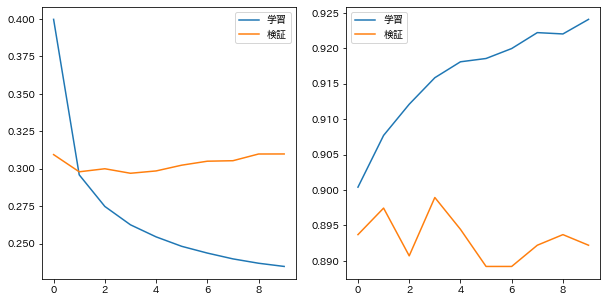

In [40]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 10)
train_predictor = Predictor(model, gen_loader(test_dataset, 1))
valid_predictor = Predictor(model, gen_loader(test_dataset, 1))
trainer.train(train_v, train_t, valid_v, valid_t)

### 76. チェックポイント

問題75から改変してもいいけど，めんどうなので73からやる

In [41]:
import os

In [42]:
class LoggingTrainer(Trainer):
    def save(self, epoch):
        torch.save({'epoch' : epoch, 'optimizer': self.optimizer}, f'result/trainer_states{epoch}.pt')
        torch.save(self.model.state_dict(), f'result/checkpoint{epoch}.pt')
    
    def train(self):
        for epoch in range(self.max_iter):
            train_loss = self.train_epoch()
            valid_loss = self.valid_epoch()
            self.save(epoch)
            print('epoch {}, train_loss:{:.5f}, valid_loss:{:.5f}'.format(epoch, train_loss, valid_loss))

In [43]:
model = Perceptron(300, 4)
task = Task()
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = LoggingTrainer(model, loaders, task, optimizer, 10)
trainer.train()

epoch 0, train_loss:0.40041, valid_loss:0.31610
epoch 1, train_loss:0.29591, valid_loss:0.29885
epoch 2, train_loss:0.27397, valid_loss:0.29614
epoch 3, train_loss:0.26215, valid_loss:0.29390
epoch 4, train_loss:0.25426, valid_loss:0.29821
epoch 5, train_loss:0.24820, valid_loss:0.30615
epoch 6, train_loss:0.24375, valid_loss:0.30611
epoch 7, train_loss:0.23998, valid_loss:0.30545
epoch 8, train_loss:0.23729, valid_loss:0.31330
epoch 9, train_loss:0.23412, valid_loss:0.31391


In [44]:
! ls result/checkpoint*

result/checkpoint0.pt  result/checkpoint4.pt  result/checkpoint8.pt
result/checkpoint1.pt  result/checkpoint5.pt  result/checkpoint9.pt
result/checkpoint2.pt  result/checkpoint6.pt
result/checkpoint3.pt  result/checkpoint7.pt


In [45]:
! ls result/trainer_states*

result/trainer_states0.pt  result/trainer_states4.pt  result/trainer_states8.pt
result/trainer_states1.pt  result/trainer_states5.pt  result/trainer_states9.pt
result/trainer_states2.pt  result/trainer_states6.pt
result/trainer_states3.pt  result/trainer_states7.pt


### 77. ミニバッチ化

In [46]:
from time import time
from contextlib import contextmanager

In [47]:
@contextmanager
def timer(description):
    start = time()
    yield
    print(description, ': {:.3f} 秒'.format(time()-start))

In [48]:
B = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [49]:
task = Task()
for b in B:
    model = Perceptron(300, 4)
    loaders = (
        gen_loader(train_dataset, b, shuffle = True),
        gen_loader(valid_dataset, 1))
    optimizer = optim.SGD(model.parameters(), 0.1 * b)
    trainer = Trainer(model, loaders, task, optimizer, 3)
    with timer(f'バッチサイズ {b}'):
        trainer.train()

epoch 0, train_loss:0.40013, valid_loss:0.31456
epoch 1, train_loss:0.29553, valid_loss:0.29903
epoch 2, train_loss:0.27484, valid_loss:0.30623
バッチサイズ 1 : 5.920 秒
epoch 0, train_loss:0.40129, valid_loss:0.31345
epoch 1, train_loss:0.29601, valid_loss:0.29988
epoch 2, train_loss:0.27442, valid_loss:0.29829
バッチサイズ 2 : 3.232 秒
epoch 0, train_loss:0.40076, valid_loss:0.31726
epoch 1, train_loss:0.29604, valid_loss:0.30524
epoch 2, train_loss:0.27509, valid_loss:0.29789
バッチサイズ 4 : 1.847 秒
epoch 0, train_loss:0.40116, valid_loss:0.31417
epoch 1, train_loss:0.29575, valid_loss:0.29871
epoch 2, train_loss:0.27388, valid_loss:0.29558
バッチサイズ 8 : 1.150 秒
epoch 0, train_loss:0.40218, valid_loss:0.31047
epoch 1, train_loss:0.29660, valid_loss:0.29759
epoch 2, train_loss:0.27419, valid_loss:0.29656
バッチサイズ 16 : 0.796 秒
epoch 0, train_loss:0.40253, valid_loss:0.31322
epoch 1, train_loss:0.29617, valid_loss:0.30428
epoch 2, train_loss:0.27434, valid_loss:0.30054
バッチサイズ 32 : 0.614 秒
epoch 0, train_loss:

### 78. GPU上での学習

In [50]:
device = torch.device('cuda')
model = Perceptron(300, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1))
optimizer = optim.SGD(model.parameters(), 0.1 * 128)
trainer = Trainer(model, loaders, task, optimizer, 3, device=device)
with timer('時間'):
    trainer.train()

epoch 0, train_loss:0.41688, valid_loss:0.31454
epoch 1, train_loss:0.29655, valid_loss:0.31738
epoch 2, train_loss:0.27658, valid_loss:0.29751
時間 : 0.839 秒


### 79. 多層ニューラルネットワーク

In [51]:
class ModelNLP79(nn.Module):
    def __init__(self, v_size, h_size, c_size):
        super().__init__()
        self.fc1 = nn.Linear(v_size, h_size)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(h_size, c_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

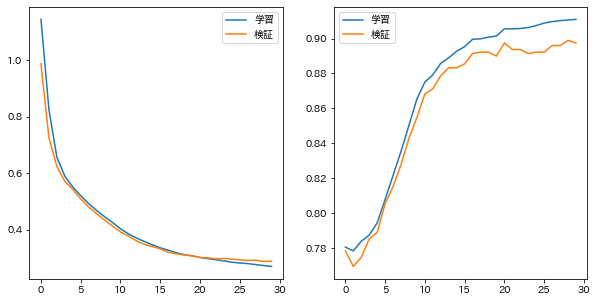

In [52]:
model = ModelNLP79(300, 128, 4)
task = Task()
loaders = (
    gen_loader(train_dataset, 128, shuffle = True),
    gen_loader(valid_dataset, 1))
optimizer = optim.SGD(model.parameters(), 0.1)
trainer = VerboseTrainer(model, loaders, task, optimizer, 30, device)
trainer.train(train_v, train_t, valid_v, valid_t)